In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk, numpy, textblob, string
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.metrics import classification_report, accuracy_score


In [3]:
file_path = "data/noemoticon_with_header.csv"
df = pd.read_csv(file_path, encoding="latin1")
print(df.info())
# X = df["text"]
# y = df["polarity"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1599999 non-null  int64 
 1   text      1599999 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB
None


In [17]:
from textpreprocesshelper import TextPreprocessHelper, NumberProcessor
helper  = TextPreprocessHelper()

In [5]:
#backup original
df["text_ori"] = df["text"].copy(deep=True)

##removing HTML and brackets.
df["text"] = df["text"].apply(helper.denoise_text)
#Expands abbreviations, e.g. "can't" → "cannot", "I'm" → "I am"
df["text"] = df["text"].apply(helper.expand_contractions)
#Remove @someone and email addresses from text
df["text"] = df["text"].apply(helper.remove_mentions_and_emails)

c:\Users\Zhou&Wan\Documents\GitHub\Text-Mining\groupproject\textpreprocesshelper.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


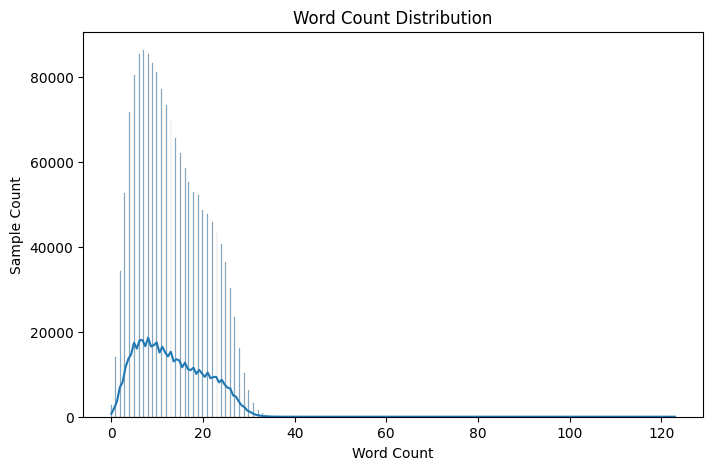


Word Count Statistics:
count    1.599999e+06
mean     1.314774e+01
std      7.225456e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      1.900000e+01
max      1.230000e+02
Name: word_count, dtype: float64


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

text_column = "text"
if text_column in df.columns:
    df["word_count"] = df[text_column].astype(str).apply(lambda x: len(x.split()))

    plt.figure(figsize=(8,5))
    sns.histplot(df["word_count"], kde=True)
    plt.title("Word Count Distribution")
    plt.xlabel("Word Count")
    plt.ylabel("Sample Count")
    plt.show()

    print("\nWord Count Statistics:")
    print(df["word_count"].describe())


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize

In [ ]:
def getBestResult(classifier = MultinomialNB(), tokenize = 0, remove_non_ascii = True, remove_punctuation = True, number = NumberProcessor.NoAction) :

    # 定义 tokenizer 选项映射
    tokenizer_options = {
        0: word_tokenize,  # 使用 nltk word_tokenize
        1: lambda x: x.split()  # 使用 Python 内置 split()
    }

    # 选择 tokenizer
    if tokenize in tokenizer_options:
        df["tokens"] = df["text"].apply(tokenizer_options[tokenize])

        #after tokenize do extra actions
        if remove_non_ascii :
            df["tokens"] = df["tokens"].apply(helper.remove_non_ascii)
        if remove_punctuation : 
            df["tokens"] = df["tokens"].apply(helper.remove_punctuation)
        if number == NumberProcessor.Remove :
            df["tokens"] = df["tokens"].apply(helper.remove_numbers)
        elif number == NumberProcessor.ToString :
            df["tokens"] = df["tokens"].apply(helper.replace_numbers)

    else:
        raise ValueError("Invalid value for `tokenize`. Choose 0 (word_tokenize) or 1 (split).")


     # 训练/测试数据集划分
    train_x, test_x, train_y, test_y = train_test_split(
        df['tokens'].apply(lambda x: ' '.join(x)),  # word_tokenize 版本
        df['polarity'],
        random_state=34,
        stratify=df['polarity']
    )

    pipeline = Pipeline([ # 构建 Pipeline
        ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}')),  # TF-IDF 向量化
        ('clf', classifier)  # 分类器，默认 Naive Bayes
    ])

    # 定义 GridSearch 参数
    parameters = {
        'tfidf__ngram_range': [(1,1), (1,2)],  # 1-gram 和 1,2-gram
        'tfidf__lowercase': [True, False], 
        'tfidf__max_features': [10000, 50000, None],  # 词汇表大小
        'tfidf__stop_words': [None, 'english'],  # 是否使用停用词
        'clf': [classifier]
    }

    '''
    (1,1) (Unigram)	['I', 'love', 'NLP']	基础 NLP 任务，如情感分析
    (1,2) (Unigram + Bigram)	['I', 'love', 'NLP', 'I love', 'love NLP']	适合上下文敏感的 NLP 任务
    (2,2) (Bigram only)	['I love', 'love NLP']	更关注短语，但可能信息量不足
    (1,3) (Unigram + Bigram + Trigram)	['I', 'love', 'NLP', 'I love', 'love NLP', 'I love NLP']	适用于复杂文本建模
    '''

    if any(isinstance(clf, LogisticRegression) for clf in parameters['clf']):
        parameters['clf__C'] = [0.1, 1.0, 10.0]  # 只有 Logistic Regression 用这个参数

    # 执行 Grid Search
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=10, scoring='accuracy', cv=3)
    grid_search.fit(train_x, train_y)

    # 打印最佳分数和参数
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    # 预测测试集
    predictions = grid_search.best_estimator_.predict(test_x)

    label_mapping = {0: "Negative", 4: "Positive"}
    test_y_labels = test_y.map(label_mapping)
    predictions_labels = pd.Series(predictions).map(label_mapping)

    # 评估模型性能
    print("Accuracy:", metrics.accuracy_score(test_y_labels, predictions_labels))
    print("Precision:", metrics.precision_score(test_y_labels, predictions_labels, average='macro'))
    print("Recall:", metrics.recall_score(test_y_labels, predictions_labels, average='macro'))
    print("F1 Score:", metrics.f1_score(test_y_labels, predictions_labels, average='macro'))

In [15]:
getBestResult(classifier = MultinomialNB(), tokenize = 0, remove_non_ascii = True, remove_punctuation = True, number = NumberProcessor.Remove)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best score: 0.801
Best parameters set:
	clf: MultinomialNB()
	tfidf__lowercase: True
	tfidf__max_features: None
	tfidf__ngram_range: (1, 2)
	tfidf__stop_words: None
Accuracy: 0.8018575
Precision: 0.8049198238862081
Recall: 0.8018575
F1 Score: 0.8013587592091365


Best score: 0.801

Best parameters set:
	clf: MultinomialNB()
	tfidf__lowercase: True
	tfidf__max_features: None
	tfidf__ngram_range: (1, 2)
	tfidf__stop_words: None

Accuracy: 0.8018575

Precision: 0.8049198238862081

Recall: 0.8018575

F1 Score: 0.8013587592091365

In [19]:
getBestResult(classifier = MultinomialNB(), tokenize = 0, remove_non_ascii = True, remove_punctuation = True, number = NumberProcessor.NoAction)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best score: 0.800
Best parameters set:
	clf: MultinomialNB()
	tfidf__lowercase: True
	tfidf__max_features: None
	tfidf__ngram_range: (1, 2)
	tfidf__stop_words: None
Accuracy: 0.8015225
Precision: 0.8046953481221668
Recall: 0.8015224999999999
F1 Score: 0.8010044557940048


getBestResult(classifier = MultinomialNB(), tokenize = 0, remove_non_ascii = True, remove_punctuation = False, number = NumberProcessor.Remove)

### Trying to get the best parameters for logistic regression from naive bayes, as logistic regression is very time consuming